In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import pandas as pd
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 9

In [2]:
file = 'katiestack/ngc2550a_ellipsefit_5.txt'
sppix = 0.93

# Starting Parameters
initial = np.array([(15,0.001,4), (15,1,1)])
# ue, re, n

def Sersic(r, ue, re, n):
    b = 2*n - (1/3) + (4/(405*n)) + (46/(25515*n**2)) + (131/(1148175*n**3)) - (2194697/(30690717750*n**4))
    cn = (2.5/np.log(10))*b
    return ue + cn*((r/re)**(1/n) - 1)

In [3]:

# Reading Data
# How many lines to skip to get data.
data=open(file,'r')
startdata='## Ellipse Parameters:'
line = 2
readline = True
while readline:
    linedata=data.readline()
    linedata=linedata.strip()
    if linedata == startdata:
        readline = False
    else:
        line = line + 1
data.close()

# How many rows to read. Tried not closing/opening but code would hang.
data=open(file,'r')
points = '## Number of points:'
l = 1
readl = True
while readl:
    linedata=data.readline()
    linedata=linedata.strip()
    if linedata == points:
        readl = False
    else:
        l = l + 1

npts=int(data.readline(l+1))
data.close()

# Zero Point
data=open(file,'r')
zeropoint = '## Zero point of magnitude:'
z = 1
rl = True
while rl:
    linedata=data.readline()
    linedata=linedata.strip()
    if linedata == zeropoint:
        rl = False
    else:
        z = z + 1
        
zpt = data.readline(z+1)
zpt = float(zpt.strip())
data.close()

In [6]:
gaia=np.genfromtxt(file,skip_header=line, max_rows=npts)
radius=gaia[:,3] # MeanRad column
radius_s = radius*sppix
counts=gaia[:,4] # Count column
mag=zpt - 2.5*np.log10(counts) 

ell = gaia[:,6]
area = np.pi*radius**2*ell
bright = mag + 2.5*np.log10(area)

dev = gaia[:,7] # Dev column
zpterr = 0.1
err = ((2.5 * dev/(np.log(10)*counts))**2 + zpterr**2)**(1/2)

radius_err = 0.01*sppix
stddev = 5
# How many std dev the error bars represent

radius_s, bright, err = zip(*sorted(zip(radius_s, bright, err)))
radius_s = np.array(radius_s)
bright = np.array(bright)
err = np.array(err)
# Sorting data to not have weird line plots

In [7]:
#Data points to specify the two regions. a-b is bulge, c-d is disk.
a = 0 #Start
b = 7 #End
c = 19
d = npts+1

popt1, cov1 = curve_fit(Sersic, # function to fit
                                     radius_s[a:b], # x data
                                     bright[a:b], # y data
                                     sigma=err[a:b], # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial[0], # starting point for fit
                                     check_finite=True, # raise ValueError if NaN encountered (don't allow errors to pass)
                                     maxfev=5000
                       )
popt_errs1 = np.sqrt(np.diag(cov1))

popt2, cov2 = curve_fit(Sersic, # function to fit
                                     radius_s[c:d], # x data
                                     bright[c:d], # y data
                                     sigma=err[c:d], # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial[1], # starting point for fit
                                     check_finite=True, # raise ValueError if NaN encountered (don't allow errors to pass)
                                     maxfev=5000
                       )

popt_errs2 = np.sqrt(np.diag(cov2))

C:\Users\katie\AppData\Local\Temp\ipykernel_11936\3992327921.py:11: RuntimeWarning: invalid value encountered in power
  return ue + cn*((r/re)**(1/n) - 1)


Data points: 32


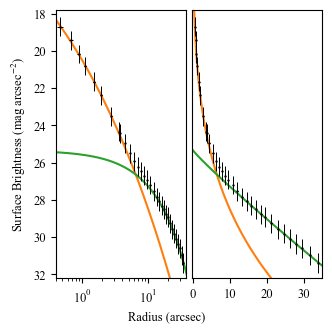

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, width_ratios=[1,1])
fig.set_figheight(3.2)
fig.set_figwidth(3.2)

fit_r = np.linspace(-5, 50, 1000)

ax1.plot(fit_r, Sersic(fit_r, *popt1), color='C1')
ax1.plot(fit_r, Sersic(fit_r, *popt2), color='C2')

ax2.plot(fit_r, Sersic(fit_r, *popt1), color='C1')
ax2.plot(fit_r, Sersic(fit_r, *popt2), color='C2')

ax1.errorbar(radius_s,bright,yerr=stddev*err, xerr=stddev*radius_err, fmt='o', markersize=0.7, color='black',elinewidth=0.7)
ax1.set_ylabel('Surface Brightness (mag arcsec$^{-2}$)')
ax1.set_ylim(17.8, 32.2)
ax1.set_xlim(0.4, 37)
ax1.invert_yaxis()
ax1.set_xscale("log")

ax2.errorbar(radius_s,bright,yerr=stddev*err, xerr=stddev*radius_err, fmt='o', markersize=0.7, color='black',elinewidth=0.7)
ax2.set_ylim(17.8, 32.2)
ax2.set_xlim(-0.2, 35)
ax2.set_xticks([0, 10, 20, 30])
ax2.invert_yaxis()
ax2.set_yticks([])

fig.supxlabel("Radius (arcsec)", fontsize=9)

fig.tight_layout(pad=0.3) # Saving the image otherwise cuts off the labels.
fig.savefig('Plots/NGC2550A.png', dpi=500) 

print("Data points: {}".format(npts))

In [160]:
print(popt)
print(popt_errs)

[32.46690151 77.33305735  1.12256548]
[ 0.46028623 13.45243512  0.42307397]


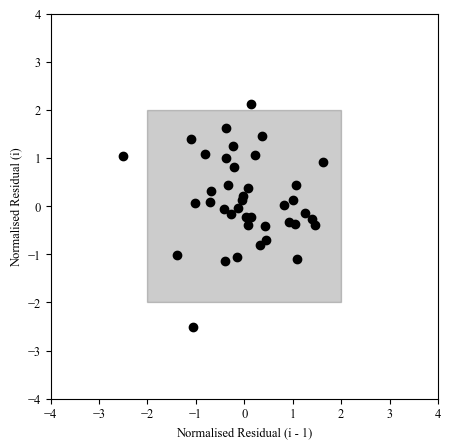

DW Statistic: 1.769129081929831


In [161]:
# Lag Plot

plt.figure(figsize=(5,5))
plt.scatter(norm_r[:-1], norm_r[1:], color='black')

# Lag plot is [:-1] (will miss the last value)
# Normal is [1:] (starts on i = 2, will miss first value)

shade = np.arange(-2,3)
plt.fill_between(x=shade, y1=-2, y2=2, color ='black', alpha=0.2)
plt.xlabel("Normalised Residual (i - 1)")
plt.ylabel("Normalised Residual (i)")
plt.xlim(-4, 4)
plt.ylim(-4,4)
plt.show()

step1 = 0
step2 = norm_r[0]**2
for i in range(1,len(norm_r)):
    Diff = norm_r[i] - norm_r[i-1]
    step1 = step1 + Diff**2 # Numerator, from i=2 to N
    step2 = step2 + norm_r[i]**2 # Denominator, from i=1 to N
    
DW = step1/step2

print("DW Statistic: {}".format(DW))
# Sometimes does not change - may need to restart notebook

In [162]:
def chisq(model_funct, model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - model_funct(x_data[i], *model_params))/y_err[i])**2 
        # NOTE again the asterisk (*) before 'model_params' here!
    return chisqval

chisq_min = chisq(Sersic, popt, radius_s[a:b], bright[a:b], err[a:b])
print('chi^2_min = {}'.format(chisq_min))

deg_freedom = len(radius[a:b]) - len(initial)
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print('$P(chi^2_min, DoF)$ = {}'.format(P))

chi^2_min = 18.22063046841647
reduced chi^2 = 0.4444056211808895
$P(chi^2_min, DoF)$ = 0.9992063145363076
